## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [13]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random

import sinogap_module as sg




### <font style="color:lightblue">Redefine</font>

In [14]:
sg.plt.rcParams['figure.dpi']=223





### <font style="color:lightblue">Configs</font>

In [15]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 0
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 1024    #16384 #32768
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 0.0002
    ,learningRateG = 0.0002
)

sg.DCfg = sg.DCfgClass(8)


### <font style="color:lightblue">Raw Read</font>

In [17]:
trainSet = sg.createTrainSet()
prepGdLoss=0

Loaded set 4176862R_Eig_Threshold-4keV
Loaded set 18515.Lamb1_Eiger_7m_45keV_360Scan
Loaded set 23574.8965435L.Eiger.32kev_org
Loaded set 23574.8965435L.Eiger.32kev_sft


### <font style="color:lightblue">Show</font>

-4.105e-01, 3.546e-03, -4.227e-01, -3.957e-01


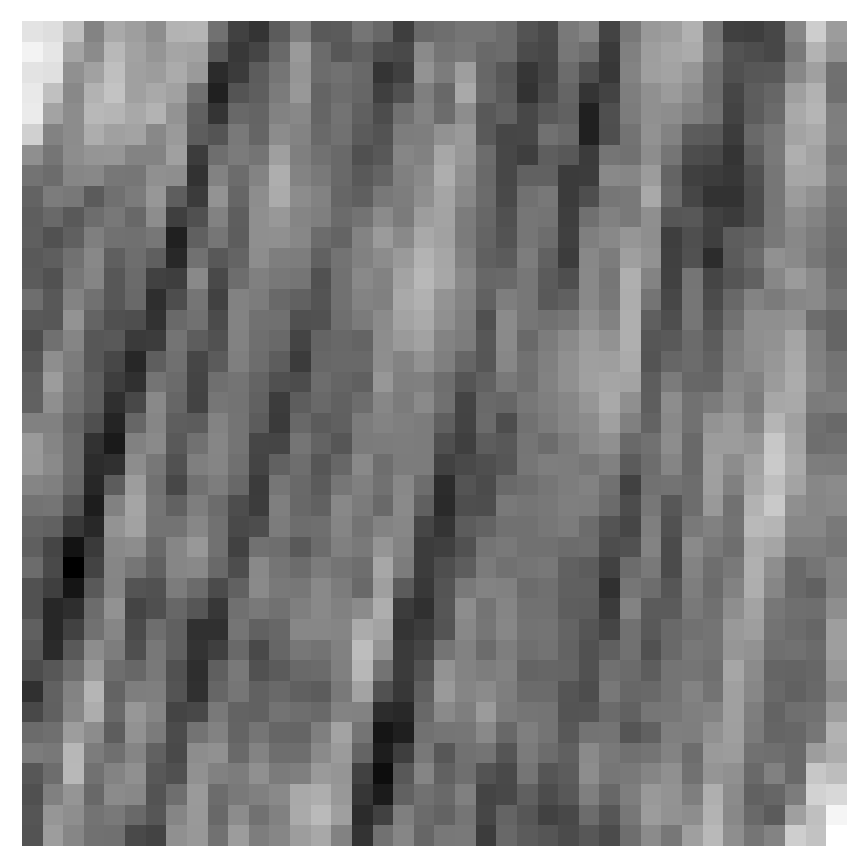

In [18]:
sg.refImages, sg.refNoises = sg.createReferences(trainSet, 0)
sg.showMe(trainSet, 0)

## <font style="color:lightblue">Models</font>

### Generator 2pix

In [19]:


class Generator2(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator2, self).__init__(2)

        #latentChannels = 7
        #self.noise2latent = nn.Sequential(
        #    nn.Linear(sg.TCfg.latentDim, self.sinoSize*latentChannels),
        #    nn.ReLU(),
        #    nn.Unflatten( 1, (latentChannels,) + self.sinoSh )
        #)

        baseChannels = 64

        def encblock(chIn, chOut, kernel, stride=1, norm=True) :
            layers = []
            layers.append(nn.Conv2d(chIn, chOut, kernel, stride=stride, bias=True))
            if norm :
                layers.append(nn.BatchNorm2d(chOut))
            layers.append(nn.LeakyReLU(0.2))
            sg.fillWheights(layers)
            return torch.nn.Sequential(*layers)
        self.encoders =  nn.ModuleList([
            encblock(  1,                baseChannels, 3, norm=False),
            encblock(  baseChannels,     baseChannels, 3),
            encblock(  baseChannels,     baseChannels, 3),
            ])

        smpl = torch.zeros((1,1,*self.sinoSh))
        for encoder in self.encoders :
            smpl = encoder(smpl)
        encSh = smpl.shape
        linChannels = math.prod(encSh)
        self.fcLink = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linChannels, linChannels),
            nn.LeakyReLU(0.2),
            nn.Linear(linChannels, linChannels),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, encSh[1:]),
        )
        sg.fillWheights(self.fcLink)

        def decblock(chIn, chOut, kernel, stride=1, norm=True) :
            layers = []
            layers.append(nn.ConvTranspose2d(chIn, chOut, kernel, stride, bias=True))
            if norm :
                layers.append(nn.BatchNorm2d(chOut))
            layers.append(nn.LeakyReLU(0.2))
            sg.fillWheights(layers)
            return torch.nn.Sequential(*layers)
        self.decoders = nn.ModuleList([
            decblock(2*baseChannels, baseChannels, 3),
            decblock(2*baseChannels, baseChannels, 3),
            decblock(2*baseChannels, baseChannels, 3, norm=False),
            ])

        self.lastTouch = nn.Sequential(
            nn.Conv2d(baseChannels+1, 1, 1),
            nn.Tanh(),
        )
        sg.fillWheights(self.lastTouch)


    def forward(self, input):

        images, _ = input
        images, orgDims = sg.unsqeeze4dim(images)
        modelIn = images.clone()
        modelIn[self.gapRng] = self.preProc(images)

        minv = modelIn.min(dim=-1).values.min(dim=-1).values
        ampl = modelIn.max(dim=-1).values.max(dim=-1).values - minv
        minv = minv[:,:,None,None]
        ampl = ampl[:,:,None,None]
        iampl = torch.where(ampl==0, 0, 2/ampl)
        modelIn = ( modelIn - minv ) * iampl - 1 # stretch

        #latent = self.noise2latent(noises)
        #modelIn = torch.cat((modelIn,latent),dim=1).to(sg.TCfg.device)
        dwTrain = [modelIn,]
        for encoder in self.encoders :
            dwTrain.append(encoder(dwTrain[-1]))
        mid = self.fcLink(dwTrain[-1])
        upTrain = [mid]
        for level, decoder in enumerate(self.decoders) :
            upTrain.append( decoder( torch.cat( (upTrain[-1], dwTrain[-1-level]), dim=1 ) ) )
        res = self.lastTouch(torch.cat( (upTrain[-1], modelIn), dim=1 ))

        patches = ( 2*res[self.gapRng] + modelIn[:,[0],:, self.gapRngX] + 1 ) * ampl / 2 + minv #destretch
        return sg.squeezeOrg(patches, orgDims)



generator2 = Generator2()
generator2 = sg.load_model(generator2, model_path="saves/gen2.pt" )
generator2 = generator2.to(sg.TCfg.device)
generator2 = generator2.requires_grad_(False)
generator2 = generator2.eval()
sg.lowResGenerators[2] = generator2




### Generator 4pix

In [20]:


class Generator4(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator4, self).__init__(4)

        #latentChannels = 7
        #self.noise2latent = nn.Sequential(
        #    nn.Linear(sg.TCfg.latentDim, self.sinoSize*latentChannels),
        #    nn.ReLU(),
        #    nn.Unflatten( 1, (latentChannels,) + self.sinoSh )
        #)

        baseChannels = 64

        def encblock(chIn, chOut, kernel, stride=1, norm=True, dopadding=False) :
            layers = []
            layers.append( nn.Conv2d(chIn, chOut, kernel, stride=stride, bias=True,
                                     padding='same', padding_mode='reflect') \
                           if stride == 1 and dopadding else \
                           nn.Conv2d(chIn, chOut, kernel, stride=stride, bias=True)
                           )
            if norm :
                layers.append(nn.BatchNorm2d(chOut))
            layers.append(nn.LeakyReLU(0.2))
            sg.fillWheights(layers)
            return torch.nn.Sequential(*layers)
        self.encoders =  nn.ModuleList([
            encblock(  1,                  baseChannels, 3, norm=False),
            encblock(  baseChannels,     2*baseChannels, 3, stride=2),
            encblock(  2*baseChannels,   2*baseChannels, 3),
            encblock(  2*baseChannels,   2*baseChannels, 3),
            ])

        smpl = torch.zeros((1,1,*self.sinoSh))
        for encoder in self.encoders :
            smpl = encoder(smpl)
        encSh = smpl.shape
        linChannels = math.prod(encSh)
        self.fcLink = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linChannels, linChannels),
            nn.LeakyReLU(0.2),
            nn.Linear(linChannels, linChannels),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, encSh[1:]),
        )
        sg.fillWheights(self.fcLink)

        def decblock(chIn, chOut, kernel, stride=1, norm=True) :
            layers = []
            layers.append(nn.ConvTranspose2d(chIn, chOut, kernel, stride, bias=True))
            if norm :
                layers.append(nn.BatchNorm2d(chOut))
            layers.append(nn.LeakyReLU(0.2))
            sg.fillWheights(layers)
            return torch.nn.Sequential(*layers)
        self.decoders = nn.ModuleList([
            decblock(4*baseChannels, 2*baseChannels, 3),
            decblock(4*baseChannels, 2*baseChannels, 3),
            decblock(4*baseChannels,   baseChannels, 4, stride=2),
            decblock(2*baseChannels,   baseChannels, 3, norm=False),
            ])

        self.lastTouch = nn.Sequential(
            nn.Conv2d(baseChannels+1, 1, 1),
            nn.Tanh(),
        )
        sg.fillWheights(self.lastTouch)


    def forward(self, input):

        images, noises = input
        images, orgDims = sg.unsqeeze4dim(images)
        modelIn = images.clone()
        modelIn[self.gapRng] = self.preProc(images)

        #latent = self.noise2latent(noises)
        #modelIn = torch.cat((modelIn,latent),dim=1).to(sg.TCfg.device)
        dwTrain = [modelIn,]
        for encoder in self.encoders :
            dwTrain.append(encoder(dwTrain[-1]))
        mid = self.fcLink(dwTrain[-1])
        upTrain = [mid]
        for level, decoder in enumerate(self.decoders) :
            upTrain.append( decoder( torch.cat( (upTrain[-1], dwTrain[-1-level]), dim=1 ) ) )
        res = self.lastTouch(torch.cat( (upTrain[-1], modelIn ), dim=1 ))

        patches = modelIn[self.gapRng] + 2 * res[self.gapRng]
        return sg.squeezeOrg(patches, orgDims)

generator4 = Generator4()
generator4 = sg.load_model(generator4, model_path="saves/gen4.pt" )
generator4 = generator4.to(sg.TCfg.device)
generator4 = generator4.requires_grad_(False)
generator4 = generator4.eval()
sg.lowResGenerators[4] = generator4




### <font style="color:lightblue">Generator</font>

In [ ]:


class Generator8(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator8, self).__init__(8)

        #latentChannels = 7
        #self.noise2latent = nn.Sequential(
        #    nn.Linear(sg.TCfg.latentDim, self.sinoSize*latentChannels),
        #    nn.ReLU(),
        #    nn.Unflatten( 1, (latentChannels,) + self.sinoSh )
        #)

        baseChannels = 64

        self.encoders =  nn.ModuleList([
            self.encblock(  1,                  baseChannels, 3, norm=False),
            self.encblock(  baseChannels,     2*baseChannels, 3, stride=2),
            self.encblock(2*baseChannels,     2*baseChannels, 3),
            self.encblock(2*baseChannels,     2*baseChannels, 3),
            self.encblock(2*baseChannels,     4*baseChannels, 3, stride=2),
            self.encblock(4*baseChannels,     4*baseChannels, 3),
            ])

        smpl = torch.zeros((1,1,*self.sinoSh))
        for encoder in self.encoders :
            smpl = encoder(smpl)
        encSh = smpl.shape
        linChannels = math.prod(encSh)
        self.fcLink = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linChannels, linChannels),
            nn.LeakyReLU(0.2),
            nn.Linear(linChannels, linChannels),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, encSh[1:]),
        )
        sg.fillWheights(self.fcLink)

        self.decoders = nn.ModuleList([
            self.decblock(8*baseChannels, 4*baseChannels, 3),
            self.decblock(8*baseChannels, 2*baseChannels, 4, stride=2),
            self.decblock(4*baseChannels, 2*baseChannels, 3),
            self.decblock(4*baseChannels, 2*baseChannels, 3),
            self.decblock(4*baseChannels,   baseChannels, 4, stride=2),
            self.decblock(2*baseChannels,   baseChannels, 3, norm=False),
            ])

        self.lastTouch = nn.Sequential(
            nn.Conv2d(baseChannels+1, 1, 1),
            nn.Tanh(),
        )
        sg.fillWheights(self.lastTouch)


    def forward(self, input):

        images, noises = input
        images, orgDims = sg.unsqeeze4dim(images)
        modelIn = images.clone()
        modelIn[self.gapRng] = self.preProc(images)

        #latent = self.noise2latent(noises)
        #modelIn = torch.cat((modelIn,latent),dim=1).to(sg.TCfg.device)
        dwTrain = [modelIn,]
        for encoder in self.encoders :
            dwTrain.append(encoder(dwTrain[-1]))
        mid = self.fcLink(dwTrain[-1])
        #return mid
        upTrain = [mid]
        for level, decoder in enumerate(self.decoders) :
            upTrain.append( decoder( torch.cat( (upTrain[-1], dwTrain[-1-level]), dim=1 ) ) )
        res = self.lastTouch(torch.cat( (upTrain[-1], modelIn ), dim=1 ))

        patches = modelIn[self.gapRng] + 2 * res[self.gapRng]
        return sg.squeezeOrg(patches, orgDims)

sg.generator = Generator8()
sg.generator.to(sg.TCfg.device)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
print(model_summary)




Layer (type:depth-idx)                   Output Shape              Param #
Generator8                               [1, 1, 40, 8]             --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 64, 38, 38]           --
│    │    └─Conv2d: 3-1                  [1, 64, 38, 38]           640
│    │    └─LeakyReLU: 3-2               [1, 64, 38, 38]           --
│    └─Sequential: 2-2                   [1, 128, 18, 18]          --
│    │    └─Conv2d: 3-3                  [1, 128, 18, 18]          73,856
│    │    └─BatchNorm2d: 3-4             [1, 128, 18, 18]          256
│    │    └─LeakyReLU: 3-5               [1, 128, 18, 18]          --
│    └─Sequential: 2-3                   [1, 128, 16, 16]          --
│    │    └─Conv2d: 3-6                  [1, 128, 16, 16]          147,584
│    │    └─BatchNorm2d: 3-7             [1, 128, 16, 16]          256
│    │    └─LeakyReLU: 3-8               [1, 128, 16, 16]          --
│  

### <font style="color:lightblue">Discriminator</font>

In [27]:

class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.param = nn.Parameter(torch.zeros(1))
    def forward(self, images):
        return torch.zeros((images.shape[0],1), device=sg.TCfg.device)


sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
#print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)



### <font style="color:lightblue">Optimizers</font>

In [28]:
sg.optimizer_G , sg.optimizer_D = sg.createOptimizers()

## <font style="color:lightblue">Restore checkpoint</font>

Probabilities of reference images: Ref: 0.000e+00, Gen: 0.000e+00, Pre: 0.000e+00.
Distances of reference images: REC: 2.228e-03, MSE: 2.228e-03, L1L: 2.284e-02.


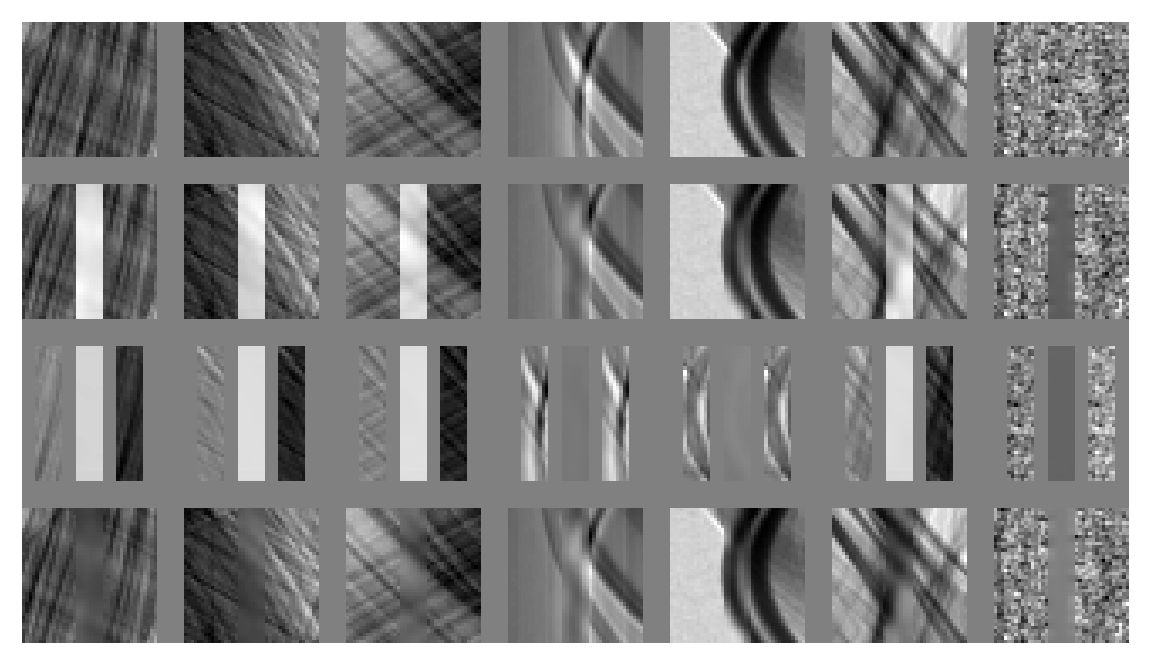

In [30]:
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.iter, sg.minGEpoch, sg.minGdLoss = sg.restoreCheckpoint()#savedCheckPoint+".pth")
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)
sg.initialTest()

## <font style="color:lightblue">Execute</font>

Epoch: 17 (16). Losses:  L1L: 1.208e-02  MSE: 3.733e-04  Rec: 3.914e-04 (3.914e-04 / 5.178e-04).
TT: 0.0000e+00 (3843722,2792),  FT: 0.0000e+00 (4445850,119),  HD: 6.433e-03 (4082994,765),  GP: 0.00000, 0.00000 
TF: 0.0000e+00 (917026,1127),  FF: 0.0000e+00 (2603752,916),  LD: 3.596e-07 (1862172,782),  R : 0.00000.


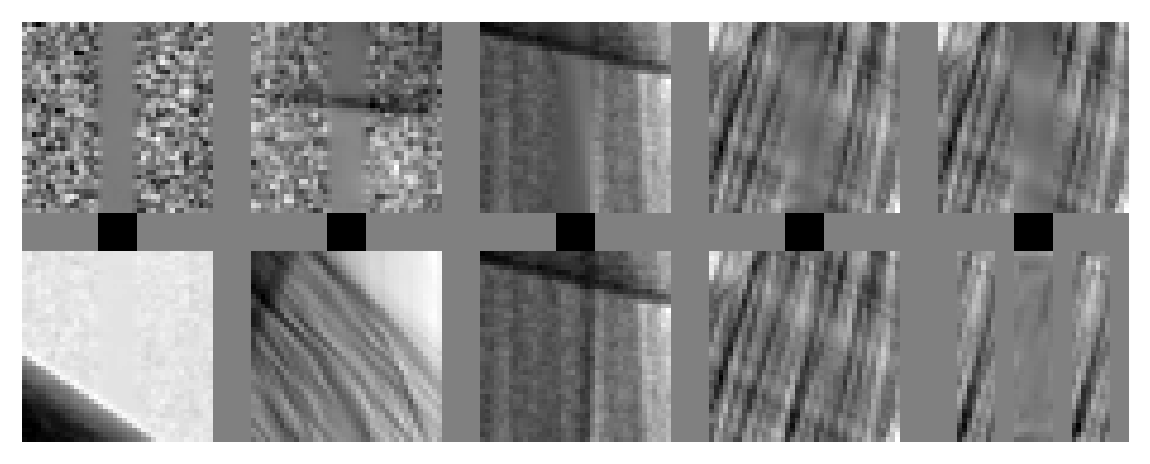

 71%|███████   | 3597/5097 [49:17<20:33,  1.22it/s]


KeyboardInterrupt: 

In [31]:

#for item in itertools.chain( sg.optimizer_D.param_groups, sg.optimizer_G.param_groups ):
#    item['lr'] *= 0.1
sg.dataLoader = sg.createTrainLoader(trainSet, num_workers=8)


#torch.autograd.set_detect_anomaly(True)
#Summary. Rec: 5.178e-04, MSE: 5.178e-04, L1L: 1.345e-02.
sg.prepGdLoss =  5.178e-04
if sg.prepGdLoss == 0:
    Rec_diff, MSE_diff, L1L_diff = sg.summarizeSet(sg.dataLoader)
    sg.prepGdLoss = Rec_diff
    sg.writer.add_scalars("Distances per epoch",
                          {'MSE0': MSE_diff
                          ,'L1L0': L1L_diff
                          ,'REC0': Rec_diff
                          }, 0 )

#
#def my_afterEachEpoch(epoch) :
#    if sg.minGEpoch < 600 :
#        return
#    if not sg.dataLoader is None :
#        del sg.dataLoader
#        sg.freeGPUmem()
#    #if sg.TCfg.batchSize < 131072 :
#    sg.TCfg.batchSize += round( 0.01 * sg.TCfg.batchSize )
#    sg.dataLoader = sg.createTrainLoader(trainSet, num_workers=24)
#    print("Batch size: ",sg.TCfg.batchSize)
#sg.afterEachEpoch = my_afterEachEpoch

sg.noAdv = True

try :
    sg.train(savedCheckPoint)
except :
    del sg.dataLoader
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    raise


 # add, arch4

## <font style="color:lightblue">Post</font>

In [ ]:
sg.initialTest()


In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()